In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException
from bs4 import BeautifulSoup
import mysql.connector

In [3]:
def connect_to_mysql():
    try:
        conn = mysql.connector.connect(
            host="localhost",     
            user="root",          
            database="product_database_daraz"  
        )
        cursor = conn.cursor()
        return conn, cursor
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None, None

In [5]:
# Function to create a table in MySQL if it does not exist
def create_table(cursor):
    create_table_query = """
    CREATE TABLE IF NOT EXISTS products (
        id INT AUTO_INCREMENT PRIMARY KEY,
        product_name VARCHAR(255),
        price VARCHAR(255),
        rating VARCHAR(255),
        stock_info VARCHAR(255)
    )
    """
    cursor.execute(create_table_query)

# Function to insert data into the MySQL database
def insert_data_into_mysql(cursor, conn, product_names, prices, ratings, stock_info):
    insert_query = """
    INSERT INTO products (product_name, price, rating, stock_info)
    VALUES (%s, %s, %s, %s)
    """
    for i in range(len(product_names)):
        cursor.execute(insert_query, (product_names[i], prices[i], ratings[i], stock_info[i]))
    conn.commit()

# Function to initialize the Selenium WebDriver
def initialize_webdriver():
    """Initialize the Selenium WebDriver with proper error handling."""
    try:
        driver = webdriver.Chrome()
        return driver
    except WebDriverException as e:
        print(f"Error initializing the WebDriver: {e}")
        return None

In [7]:
# Function to fetch the page source using Selenium
def fetch_page_source(url, driver, wait_time=10):
    try:
        driver.get(url)
        WebDriverWait(driver, wait_time).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'Bm3ON'))
        )
        return BeautifulSoup(driver.page_source, "lxml")
    except TimeoutException as e:
        print(f"Timeout fetching the page: {url}")
        return None
    except WebDriverException as e:
        print(f"WebDriverException while fetching the page: {url}, Error: {e}")
        return None

def extract_product_info(soup):
    product_names, prices, ratings, stock_info = [], [], [], []
    products = soup.find_all('div', class_='Bm3ON')
    
    for product in products:
        name_tag = product.find('a', title=True)
        product_name = name_tag['title'].strip() if name_tag else "N/A"
        product_names.append(product_name[:50] + '...' if len(product_name) > 50 else product_name)  # Truncate long names

        price_tag = product.find('span', class_='ooOxS')
        price = price_tag.text.strip() if price_tag else "N/A"
        prices.append(price)

        rating_tag = product.find('div', class_='mdmmT')
        rating = rating_tag.text.strip() if rating_tag else "No rating"
        ratings.append(rating)

        stock_tag = product.find('span', class_='_1cEkb')
        stock = stock_tag.text.strip() if stock_tag else "No stock info"
        stock_info.append(stock)

    return product_names, prices, ratings, stock_info


In [9]:
def main():
    # Connect to MySQL and create table
    conn, cursor = connect_to_mysql()
    if conn is None or cursor is None:
        return
    create_table(cursor)
    
    base_url = 'https://www.daraz.com.bd/routers/?page={page_number}'
    start_page = int(input("Enter the start page number: "))
    end_page = int(input("Enter the end page number: "))

    driver = initialize_webdriver()
    if not driver:
        return

    all_product_names, all_prices, all_ratings, all_stock_info = [], [], [], []

    try:
        for page_number in range(start_page, end_page + 1):
            url = base_url.format(page_number=page_number)
            print(f"Fetching data from {url}")
            soup = fetch_page_source(url, driver)
            if not soup:
                print(f"Skipping page {page_number} due to an error.")
                continue

            product_names, prices, ratings, stock_info = extract_product_info(soup)

            # Append current page's data to the main lists
            all_product_names.extend(product_names)
            all_prices.extend(prices)
            all_ratings.extend(ratings)
            all_stock_info.extend(stock_info)

        # Insert scraped data into MySQL database
        insert_data_into_mysql(cursor, conn, all_product_names, all_prices, all_ratings, all_stock_info)
    
    finally:
        driver.quit()
        cursor.close()
        conn.close()

In [13]:
if __name__ == "__main__":
    main()

Enter the start page number:  1
Enter the end page number:  4


Fetching data from https://www.daraz.com.bd/routers/?page=1
Fetching data from https://www.daraz.com.bd/routers/?page=2
Fetching data from https://www.daraz.com.bd/routers/?page=3
Fetching data from https://www.daraz.com.bd/routers/?page=4


In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
# Function to connect to MySQL database
def connect_to_mysql():
    try:
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            database="product_database"
        )
        return conn
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

In [43]:
# Function to fetch data from MySQL with ID filtering for a range
def fetch_data_from_mysql(start_id=None, end_id=None):
    conn = connect_to_mysql()
    if conn is None:
        return pd.DataFrame()
    
    if start_id is not None and end_id is not None:
        query = f"SELECT id, product_name, price, rating, stock_info FROM products WHERE id BETWEEN {start_id} AND {end_id}"
    else:
        query = "SELECT id, product_name, price, rating, stock_info FROM products"
    
    df = pd.read_sql(query, conn)
    conn.close()

    df['Price (BDT)'] = df['price'].str.extract(r'(\d+,\d+|\d+)').replace(',', '', regex=True).astype(float)
    df['Rating'] = df['rating'].str.extract(r'(\d+)').fillna(0).astype(int)  
    df['Stock Sold'] = df['stock_info'].str.extract(r'(\d+(\.\d+)?K?)')[0].replace({'K': '000'}, regex=True).astype(float)
    df['product_name'] = df['product_name'].apply(lambda x: x[:30] + '...' if len(x) > 30 else x)

    return df

In [45]:
def visualize_data(df):
    print(df[['id', 'product_name', 'price', 'rating', 'stock_info', 'Price (BDT)', 'Stock Sold']].to_string(index=False))
    # Display the data in a simple table
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    
    df['Short Product Name'] = df['product_name'].apply(lambda x: x[:30] + '...' if len(x) > 30 else x)

    fig, ax = plt.subplots(3, 1, figsize=(15, 15))  

    # Bar plot for prices
    ax[0].barh(df['Short Product Name'], df['Price (BDT)'], color='skyblue')
    ax[0].set_xlabel('Price (BDT)', fontsize=14)
    ax[0].set_ylabel('Product Name', fontsize=14)
    ax[0].set_title('Product Prices', fontsize=16)
    ax[0].tick_params(axis='y', labelsize=10)  

    # Bar plot for ratings
    ax[1].barh(df['Short Product Name'], df['Rating'], color='orange')
    ax[1].set_xlabel('Rating', fontsize=14)
    ax[1].set_ylabel('Product Name', fontsize=14)
    ax[1].set_title('Product Ratings', fontsize=16)
    ax[1].tick_params(axis='y', labelsize=10)

    # Bar plot for stock sold
    ax[2].barh(df['Short Product Name'], df['Stock Sold'], color='lightgreen')
    ax[2].set_xlabel('Stock Sold', fontsize=14)
    ax[2].set_ylabel('Product Name', fontsize=14)
    ax[2].set_title('Stock Sold for Each Product', fontsize=16)
    ax[2].tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    
    plt.savefig('product_visualization.png', format='png', dpi=300)
    plt.show()

In [47]:
def display_data():
    df = fetch_data_from_mysql()

    if df.empty:
        print("No data found in the database.")
        return

    print("\nDo you want to filter data? [1] By Price Range [2] By ID Range [3] No Filter")
    choice = int(input("Enter your choice: "))

    if choice == 1:
        price_min = float(input("Enter the minimum price: "))
        price_max = float(input("Enter the maximum price: "))
        df = df[(df['Price (BDT)'] >= price_min) & (df['Price (BDT)'] <= price_max)]
    elif choice == 2:
        start_id = int(input("Enter the start ID: "))
        end_id = int(input("Enter the end ID: "))
        df = fetch_data_from_mysql(start_id=start_id, end_id=end_id)

    if df.empty:
        print("No data available for the selected filter.")
        return

    visualize_data(df)

In [49]:
# Main function
def main():
    display_data()

/tmp/ipykernel_52490/3527154306.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)



Do you want to filter data? [1] By Price Range [2] By ID Range [3] No Filter


Enter your choice:  2
Enter the start ID:  3
Enter the end ID:  23


/tmp/ipykernel_52490/3527154306.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


 id                      product_name   price    rating    stock_info  Price (BDT)  Stock Sold
  3 WIFI Router - UPS | Backup Tim... ৳ 1,799 No rating No stock info       1799.0         NaN
  4 TP-Link Archer C54 AC1200 Wire... ৳ 2,290    (1465)     6.0K sold       2290.0         6.0
  5 Cudy WR1200 AC1200 Dual Band S... ৳ 2,399     (393)     1.5K sold       2399.0         1.5
  6 TP-Link Archer C64 AC1200 Wire... ৳ 3,079    (1022)     3.9K sold       3079.0         3.9
  7 TP-Link Archer C6 V4 - Support... ৳ 3,559    (1490)     6.0K sold       3559.0         6.0
  8 Xiaomi WiFi Range Extender N30... ৳ 1,449     (217)     1.5K sold       1449.0         1.5
  9       Mi Wi-Fi Range Extender Pro ৳ 1,580 No rating       14 sold       1580.0        14.0
 10 Mi router 4a ( gigabite editio... ৳ 1,899      (33)      229 sold       1899.0       229.0
 11 TP-Link TL-WR840N V6.2 300Mbps... ৳ 1,429    (1358)     7.7K sold       1429.0         7.7
 12 Mercusys AC12 AC1200 Dual Band... ৳ 2,059     

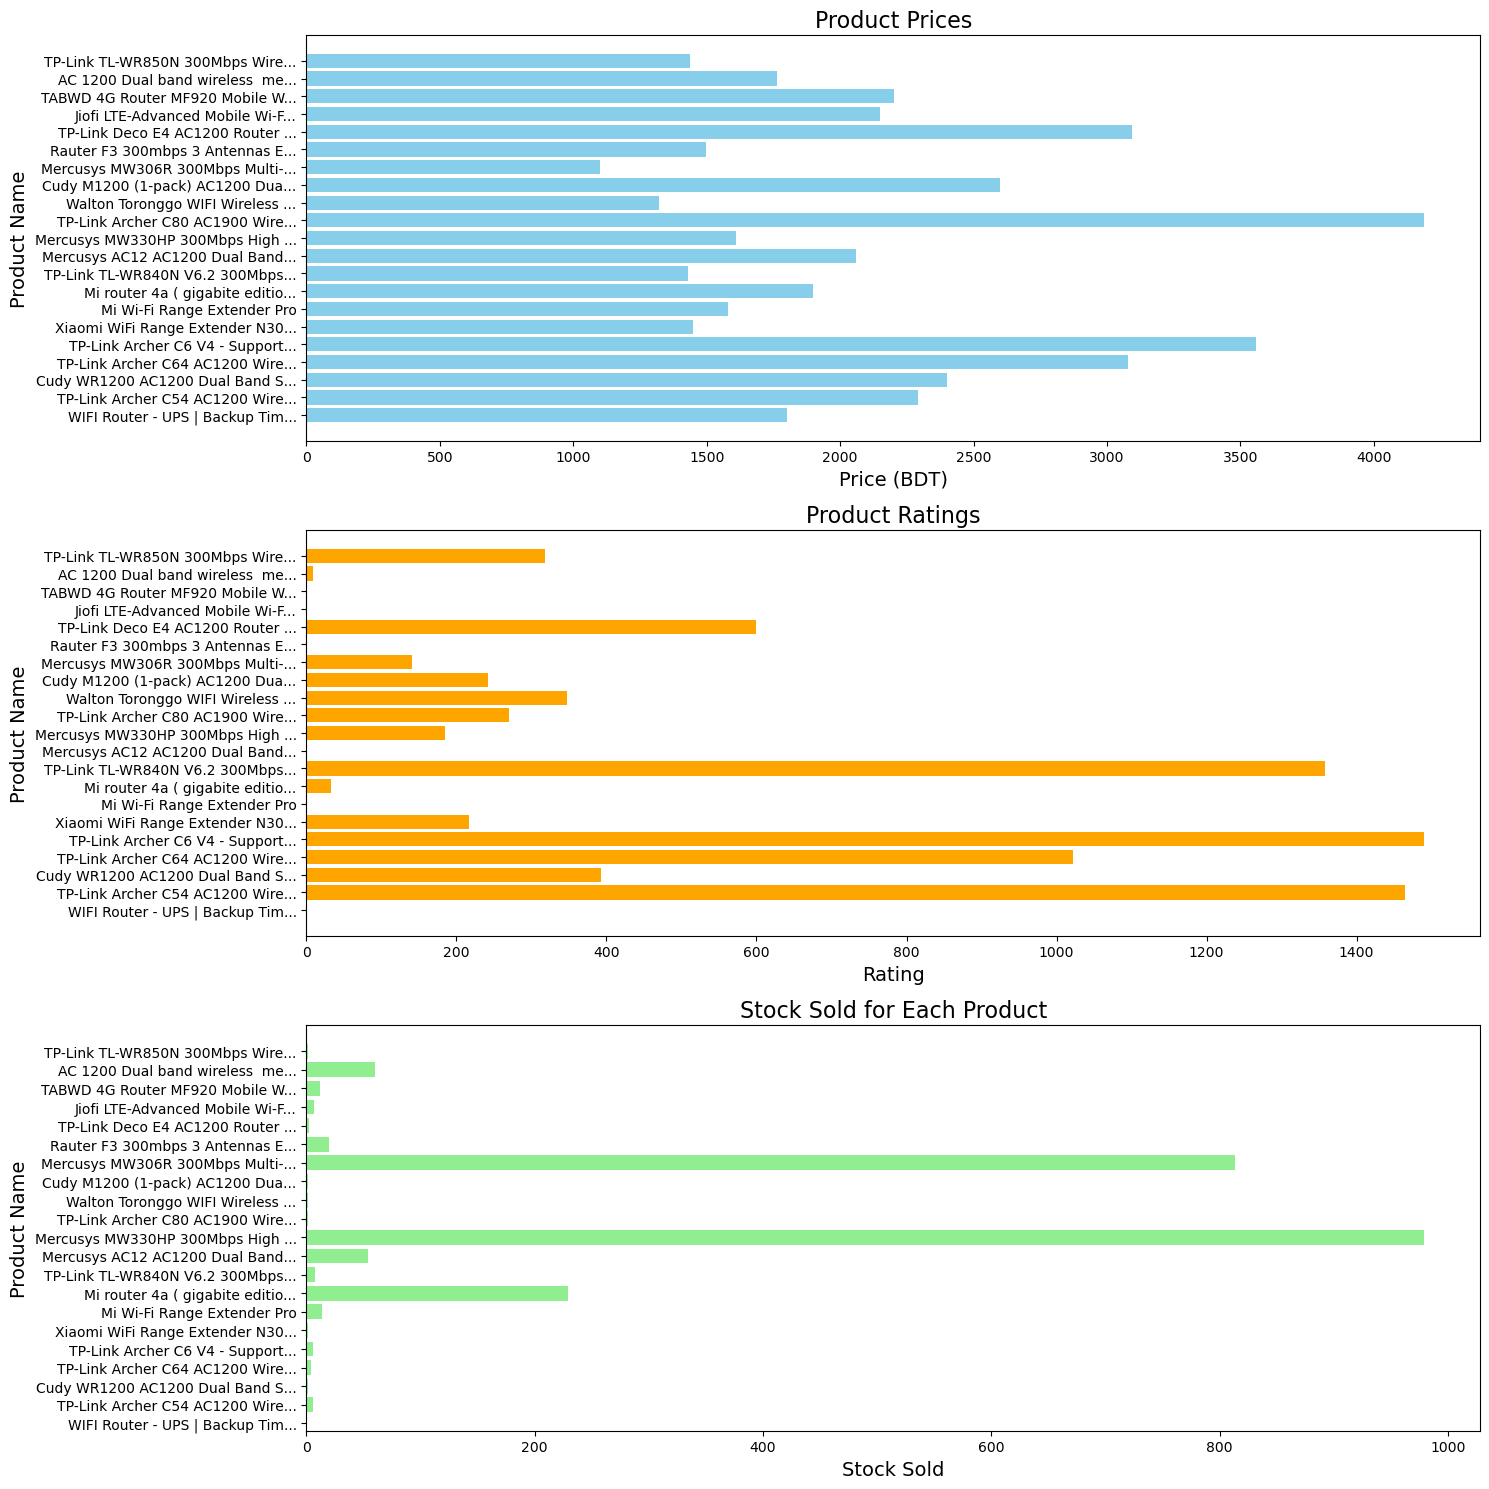

In [53]:
if __name__ == "__main__":
    main()

/tmp/ipykernel_52490/3527154306.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)



Do you want to filter data? [1] By Price Range [2] By ID Range [3] No Filter


Enter your choice:  1
Enter the minimum price:  800
Enter the maximum price:  1800


 id                      product_name   price    rating    stock_info  Price (BDT)  Stock Sold
  1 TP-Link TL-WR820N (V2) 300 Mbp... ৳ 1,189     (727)     3.8K sold       1189.0         3.8
  2 Mi Wifi Router 4C 300Mbps With... ৳ 1,320      (40)      473 sold       1320.0       473.0
  3 WIFI Router - UPS | Backup Tim... ৳ 1,799 No rating No stock info       1799.0         NaN
  8 Xiaomi WiFi Range Extender N30... ৳ 1,449     (217)     1.5K sold       1449.0         1.5
  9       Mi Wi-Fi Range Extender Pro ৳ 1,580 No rating       14 sold       1580.0        14.0
 11 TP-Link TL-WR840N V6.2 300Mbps... ৳ 1,429    (1358)     7.7K sold       1429.0         7.7
 13 Mercusys MW330HP 300Mbps High ... ৳ 1,608     (185)      979 sold       1608.0       979.0
 15 Walton Toronggo WIFI Wireless ... ৳ 1,320     (348)     1.6K sold       1320.0         1.6
 17 Mercusys MW306R 300Mbps Multi-... ৳ 1,100     (141)      813 sold       1100.0       813.0
 18 Rauter F3 300mbps 3 Antennas E... ৳ 1,499 No r

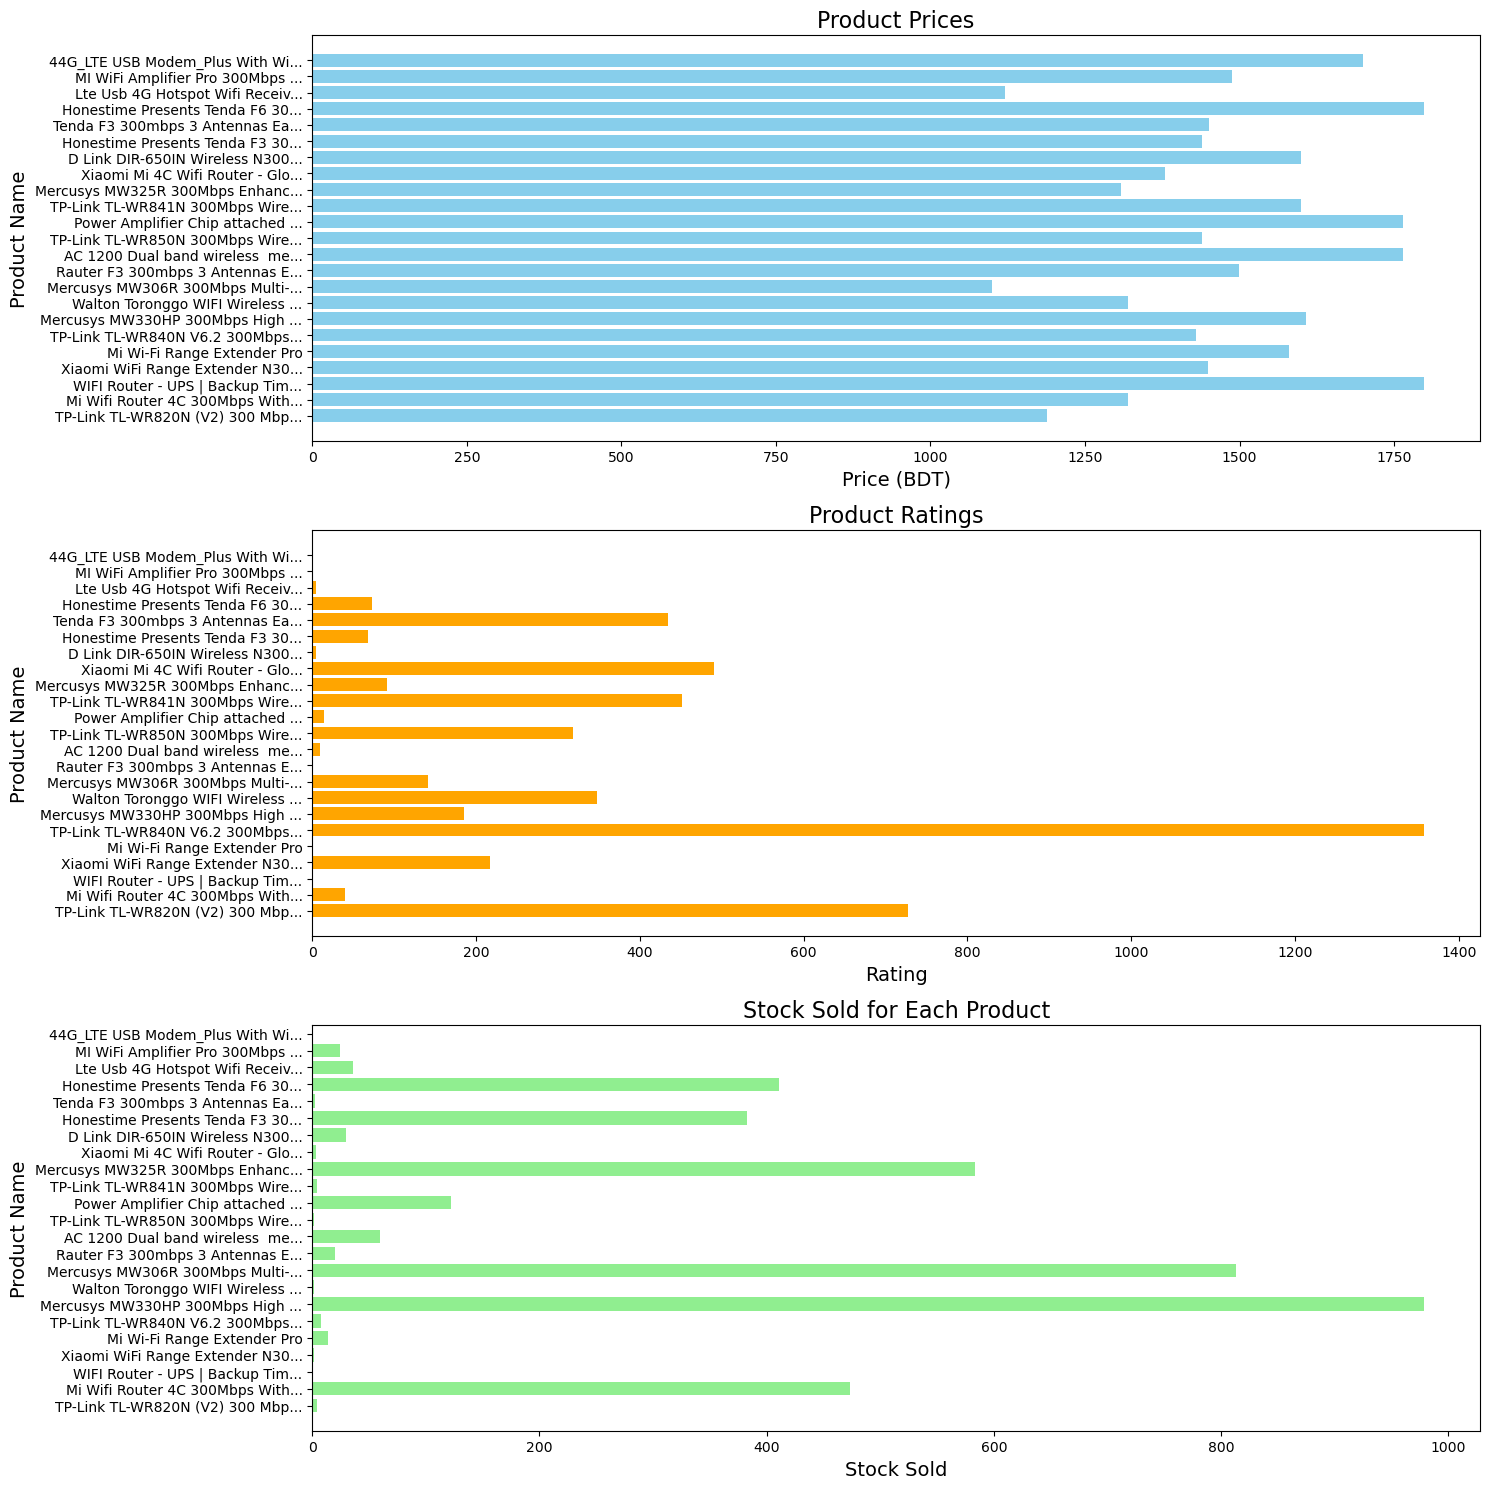

In [57]:
if __name__ == "__main__":
    main()

/tmp/ipykernel_52490/3527154306.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)



Do you want to filter data? [1] By Price Range [2] By ID Range [3] No Filter


Enter your choice:  3


 id                      product_name   price    rating    stock_info  Price (BDT)  Stock Sold
  1 TP-Link TL-WR820N (V2) 300 Mbp... ৳ 1,189     (727)     3.8K sold       1189.0         3.8
  2 Mi Wifi Router 4C 300Mbps With... ৳ 1,320      (40)      473 sold       1320.0       473.0
  3 WIFI Router - UPS | Backup Tim... ৳ 1,799 No rating No stock info       1799.0         NaN
  4 TP-Link Archer C54 AC1200 Wire... ৳ 2,290    (1465)     6.0K sold       2290.0         6.0
  5 Cudy WR1200 AC1200 Dual Band S... ৳ 2,399     (393)     1.5K sold       2399.0         1.5
  6 TP-Link Archer C64 AC1200 Wire... ৳ 3,079    (1022)     3.9K sold       3079.0         3.9
  7 TP-Link Archer C6 V4 - Support... ৳ 3,559    (1490)     6.0K sold       3559.0         6.0
  8 Xiaomi WiFi Range Extender N30... ৳ 1,449     (217)     1.5K sold       1449.0         1.5
  9       Mi Wi-Fi Range Extender Pro ৳ 1,580 No rating       14 sold       1580.0        14.0
 10 Mi router 4a ( gigabite editio... ৳ 1,899     

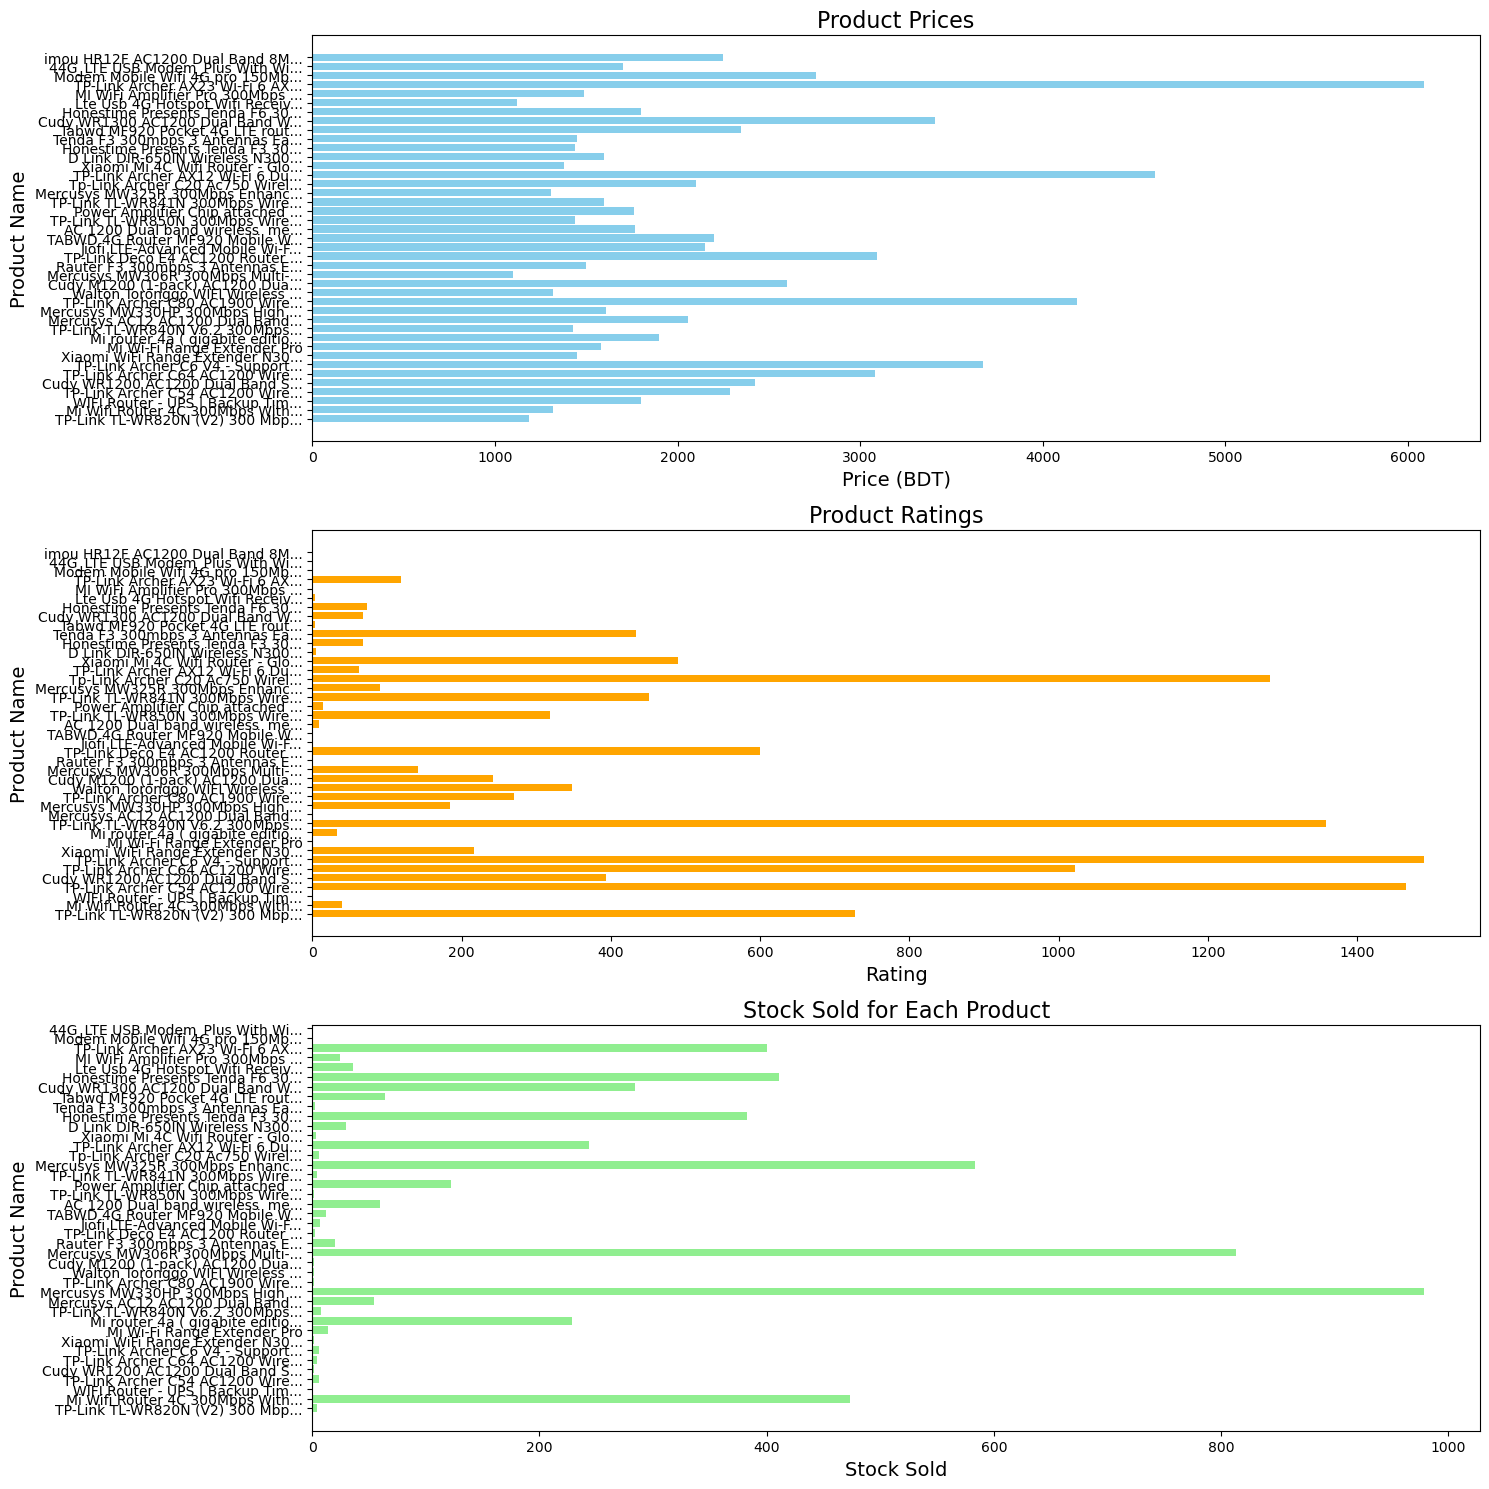

In [59]:
if __name__ == "__main__":
    main()